In [28]:
import pandas as pd
import random
import math

# read in time point 1 for training
# train on it - model 1
# test on tp 2
# read tp 2
# add it to xgb - model 2
# test on tp 3
# read tp 3
# add it to xgb - model 3
# test on tp 4
# test model 1
data = pd.read_csv('~/ctgan/data/annualized_SD_std_avg_per_variety_99-01-03.csv')
data.head()

,Unnamed: 0,State,City,Date Sown,Variety,Date of Cut,Yield (tons/acre),Total Radiation (W/m^2),Total Rainfall (mm),Avg Min Temp (C),Avg Max Temp (C),Class,Avg of AAYPVPP,STD AAYPVP,Num STDs,Avg Yield of Varieties Per Cut,Annual Avg Yield,Avg Annual Yield Per Variety Per Plant
0,177,South Dakota,Highmore,5/5/1998,Frontier 2000,8/3/1999,0.71,146151.1,924.63,4.497544,17.347632,0,0.89991,0.43275,0.670340,0.806842,1.447892,1.19
1,172,South Dakota,Highmore,5/5/1998,WL 232HQ,8/3/1999,0.81,146151.1,924.63,4.497544,17.347632,1,0.89991,0.43275,0.993852,0.806842,1.447892,1.33
2,173,South Dakota,Highmore,5/5/1998,Goldrush 747,8/3/1999,0.81,146151.1,924.63,4.497544,17.347632,1,0.89991,0.43275,0.970744,0.806842,1.447892,1.32
3,174,South Dakota,Highmore,5/5/1998,TMF Multiplier II,8/3/1999,0.75,146151.1,924.63,4.497544,17.347632,1,0.89991,0.43275,0.878312,0.806842,1.447892,1.28
4,175,South Dakota,Highmore,5/5/1998,Pioneer Brand 53V63,8/3/1999,0.75,146151.1,924.63,4.497544,17.347632,1,0.89991,0.43275,0.878312,0.806842,1.447892,1.28


In [29]:
# from sdv.tabular import CTGAN

# model = CTGAN()
# model.fit(data)

samples_out = 10000 # total number of samples/records to generate/synthesize
no_stds = .87 # number of standard deviations within which synthesized values must fall
# hi_stds = 2.4 #4.7
# lo_stds = 1.3
number_of_classes = (data['Class'].unique()).size # number of unique classes in input data

data_len = len(data.index)
F = [] # a list of the feature vectors dataframes, one per class
for class_no in range(number_of_classes):
    df = pd.DataFrame(data[data['Class'] == class_no])
    F.append(df)

    
def synthesize_tabular_data(F, samples_out, no_stds, no_classes, no_records):
    new_F = []
    new_yields = []
    new_rads = []
    new_rains = []
    new_max_temps = []
    new_min_temps = []
    
    for index, entry in enumerate(F):
        yield_ = entry['Yield (tons/acre)']
        mean_yield = yield_.mean()
        std_yield = yield_.std()
        total_rad = entry['Total Radiation (W/m^2)']
        mean_rad = total_rad.mean()
        std_rad = total_rad.std()
        total_rain = entry['Total Rainfall (mm)']
        mean_rain = total_rain.mean()
        std_rain = total_rain.std()
        avg_max_temp = entry['Avg Max Temp (C)']
        mean_max_temp = avg_max_temp.mean()
        std_max_temp = avg_max_temp.std()
        avg_min_temp = entry['Avg Min Temp (C)']
        mean_min_temp = avg_min_temp.mean()
        std_min_temp = avg_min_temp.std()
        
        # calculate potcii: percentage of this class in input
        potcii = (len(entry)/no_records)
        no_records_to_generate = round(potcii * samples_out)
        
        for i in range(no_records_to_generate):
            num_stds = no_stds
#             num_stds = random.uniform(.2, .7)
#             if (index == 0 and i % 30 == 0):
#                 num_stds = lo_stds
#             elif ((index == number_of_classes - 1 or index == number_of_classes - 2) and i % 30 == 0):
#                 num_stds = hi_stds
                
            new_yield = random.uniform(mean_yield - std_yield * num_stds, mean_yield + std_yield * num_stds)
            new_rad = random.uniform(mean_rad - std_rad * num_stds, mean_rad + std_rad * num_stds)
            new_rain = random.uniform(mean_rain - std_rain * num_stds, mean_rain + std_rain * num_stds)
            new_max_temp = random.uniform(mean_max_temp - std_max_temp * num_stds, mean_max_temp + std_max_temp * num_stds)
            new_min_temp = random.uniform(mean_min_temp - std_min_temp * num_stds, mean_min_temp + std_min_temp * num_stds)
            
            new_yields.append(new_yield)
            new_rads.append(new_rad)
            new_rains.append(new_rain)
            new_max_temps.append(new_max_temp)
            new_min_temps.append(new_min_temp)
            
        concat_yields = pd.concat([yield_, pd.DataFrame(new_yields)])
        concat_rads = pd.concat([total_rad, pd.DataFrame(new_rads)])
        concat_rain = pd.concat([total_rain, pd.DataFrame(new_rains)])
        concat_max_temps = pd.concat([avg_max_temp, pd.DataFrame(new_max_temps)])
        concat_min_temps = pd.concat([avg_min_temp, pd.DataFrame(new_min_temps)])
        new_df = pd.DataFrame()
        new_df['Yield (tons/acre)'] = concat_yields
        new_df['Total Radiation (W/m^2)'] = concat_rads
        new_df['Total Rainfall (mm)'] = concat_rain
        new_df['Avg Max Temp (C)'] = concat_max_temps
        new_df['Avg Min Temp (C)'] = concat_min_temps
        new_df['Class'] = index
        print(index)
        new_F.append(new_df)
        
    return pd.concat(new_F)

new_data = synthesize_tabular_data(F, samples_out, no_stds, number_of_classes, data_len)

0
1
2


In [30]:
# new_data = model.sample(10000)

In [31]:
new_data.to_csv('data/XGB_SITS_0408_SD99_01_03_to_04_2.csv')
new_data.head()

,Yield (tons/acre),Total Radiation (W/m^2),Total Rainfall (mm),Avg Max Temp (C),Avg Min Temp (C),Class
0,0.71,146151.10,924.63,17.347632,4.497544,0
19,0.50,366100.83,2151.68,12.922896,1.780212,0
47,0.53,285497.24,1966.28,16.886730,4.743483,0
48,0.50,285497.24,1966.28,16.886730,4.743483,0
78,0.83,370757.16,1876.98,15.331306,1.986993,0


In [32]:
# get aggregate data
targetDataLoc = '~/ctgan/data/annualized_SD_std_avg_per_variety_2004.csv'
#boostDataLoc = '~/ctgan/data/annualized_SD_std_avg_per_variety_2003.csv'

targetDf = pd.read_csv(targetDataLoc) #pd.read_csv(targetDataLoc)
aggDf = new_data #pd.read_csv(aggDataLoc)
#boostDf = pd.read_csv(boostDataLoc)

In [33]:
############## imports
# general
import statistics
import datetime
#from sklearn.externals import joblib # save and load models
import random
# data manipulation and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

## machine learning stuff
# preprocessing
from sklearn import preprocessing
# feature selection
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_regression
# pipeline
from sklearn.pipeline import Pipeline
# train/testing
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score  
# error calculations
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# models
from sklearn.linear_model import LinearRegression # linear regression
from sklearn.linear_model import BayesianRidge #bayesisan ridge regression
from sklearn.svm import SVC  # support vector machines classification
from sklearn.gaussian_process import GaussianProcessRegressor # import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor # k-nearest neightbors for regression
from sklearn.neural_network import MLPRegressor # neural network for regression
from sklearn.neural_network import MLPClassifier # neural network for classification
from sklearn.tree import DecisionTreeRegressor # decision tree regressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor  # random forest regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier # adaboost for classification
import xgboost as xgb
# saving models
# from sklearn.externals import joblib
import joblib

# import the API
APILoc = 'API/'

import sys
sys.path.insert(0, APILoc)

from API import *

In [34]:
# filter out the features that will not be used by the machine learning models

xColumnsToKeep = ["Total Radiation (W/m^2)","Total Rainfall (mm)", "Avg Max Temp (C)", "Avg Min Temp (C)"]

# the target to keep
yColumnsToKeep = ["Yield (tons/acre)"]

# get a dataframe containing the features and the targets
xDf = aggDf[xColumnsToKeep]
test_xDf = targetDf[xColumnsToKeep]
# boost_xDf = boostDf[xColumnsToKeep]

yDf = aggDf[yColumnsToKeep]
test_yDf = targetDf[yColumnsToKeep]
# boost_yDf = boostDf[yColumnsToKeep]

# reset the index
xDf = xDf.reset_index(drop=True)
yDf = yDf.reset_index(drop=True)
test_xDf = test_xDf.reset_index(drop=True)
test_yDf = test_yDf.reset_index(drop=True)
# boost_xDf = boost_xDf.reset_index(drop=True)
# boost_yDf = boost_yDf.reset_index(drop=True)

pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 500)

xCols = list(xDf)

In [35]:
# hide the warnings because training the neural network caues lots of warnings.
import warnings
warnings.filterwarnings('ignore')

# make the parameter grids for sklearn's gridsearchcv
rfParamGrid = {
        'model__n_estimators': [5, 10, 25, 50, 100], # Number of estimators
        'model__max_depth': [5, 10, 15, 20], # Maximum depth of the tree
        'model__criterion': ["gini"]
    }
knnParamGrid ={
        'model__n_neighbors':[2,5,10],
        'model__weights': ['uniform', 'distance'],
        'model__leaf_size': [5, 10, 30, 50]    
    }
svrParamGrid = {
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__C': [0.1, 1.0, 5.0, 10.0],
        'model__gamma': ["scale", "auto"],
        'model__degree': [2,3,4,5]
    }
nnParamGrid = {
        'model__hidden_layer_sizes':[(3), (5), (10), (3,3), (5,5), (7,7)],
        'model__solver': ['sgd', 'adam'],
        'model__learning_rate' : ['constant', 'invscaling', 'adaptive'],
        'model__learning_rate_init': [0.1, 0.01, 0.001]      
    }

linRegParamGrid = {}

bayesParamGrid={
        'model__n_iter':[100,300,500]
    }

dtParamGrid = {
    'model__criterion': ['gini'],
    'model__max_depth': [5,10,25,50,100]
    }

xgbParamGrid = {}

aModelList = [#(RandomForestClassifier(), rfParamGrid, "rfTup.pkl")]#,
              #(KNeighborsRegressor(), knnParamGrid, "knnTup.pkl"),
              #(SVC(), svrParamGrid, "svrTup.pkl")]#,
             #(MLPClassifier(), nnParamGrid, "nnTup.pkl")]#,
             #(LinearRegression(), linRegParamGrid, "linRegTup.pkl")]#,
             #(BayesianRidge(), bayesParamGrid, "bayesTup.pkl"),
             #(DecisionTreeClassifier(), dtParamGrid, "dtTup.pkl")]
             (xgb.XGBRegressor(), xgbParamGrid, "xgbTup.pkl")]

N = 10
workingDir = 'working_dir'
numFeatures = 4 # 11

model:  xgbTup
Avg MAE:  128.972
Avg R squared:  0.594
Best MAE:  123.625
Best R squared:  0.625
 
test results on our test data: 
                            OLS Regression Results                            
Dep. Variable:      Yield (tons/acre)   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     89.69
Date:                Sat, 08 Apr 2023   Prob (F-statistic):           8.60e-14
Time:                        16:09:58   Log-Likelihood:                 37.806
No. Observations:                  66   AIC:                            -71.61
Df Residuals:                      64   BIC:                            -67.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]


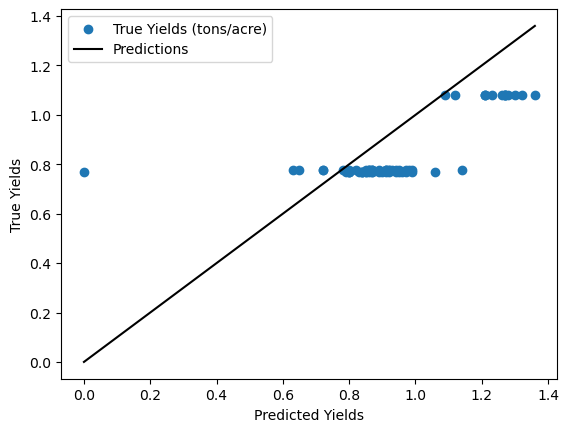

In [36]:
saveMLResults(test_xDf, test_yDf, N, xDf, yDf, aModelList, workingDir, numFeatures, printResults=True)